In [94]:
import pandas as pd
import keras
import numpy as np
import sys
sys.path.append('../')
from src.models import three_input_model
from src.generator import generator_three_inputs
sys.path.append('/notebook')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
% matplotlib inline

In [95]:
# import dataframe with filenames and labels
sample = pd.read_csv('../labels/training_labels_updated_111219.csv')
sample['temp_label'] = sample['final_label'].apply(lambda x: np.round(x))
sample['temp_label'] = sample['temp_label'].astype('int').astype('str')
sample['final_label'] =  sample['final_label'].astype('str')

train_data, test_data = train_test_split(sample, test_size = 0.25, random_state = 100)

In [96]:
# artificially oversample the minority class
zero_class = train_data[train_data.temp_label == '0']
train_data = (train_data.append(zero_class)).append(zero_class)

(489, 10)

In [3]:
### test tabular
tabular_df = sample[['MBL', 'ADDR_NUM']]
tabular_df['test_col'] = np.random.normal(size=tabular_df.shape[0])
tabular_df['test_col2'] = np.random.normal(2,3,size=tabular_df.shape[0])
tabular_df.drop(['ADDR_NUM'], axis = 1, inplace = True)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata

In [4]:
# input parameters
batch_size = 8
epochs = 5

In [5]:
model = three_input_model(n_tabular_cols = 2, gsv_image_dim = (128, 128, 3), sat_image_dim = ((128, 128, 4)), 
                          n_classes = 1, loss_fn = 'binary_crossentropy')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gsv_image_input (InputLayer)    (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
aerial_image_input (InputLayer) (None, 128, 128, 4)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 126, 126, 128 3584        gsv_image_input[0][0]            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 126, 126, 128 4736        aerial_image_input[0][0]         
__________________________________________________________________________________________________
max_poolin

In [6]:
#implement class weights as an easy first attempt to handle imbalanced class problem
# class_weight = {1.0: 1,
#                 0.0: 2}

In [7]:
history = model.fit_generator(
    
                # train 
                generator_three_inputs(train_data, tabular_df, [ 'test_col', 'test_col2'],                       
                           aerial_dir = '../data/training/aerial_images/', 
                           gsv_dir ='../data/training/sv_images/', 
                           batch_size = batch_size, 
                           gsv_image_dim = (128,128, 3), aer_image_dim = (128,128, 4) , 
                           y_column = 'temp_label'),
    
                # validation
                validation_data = generator_three_inputs(test_data, tabular_df, ['test_col', 'test_col2'],                       
                           aerial_dir = '../data/training/aerial_images/', 
                           gsv_dir ='../data/training/sv_images/', 
                           batch_size = batch_size, 
                           gsv_image_dim = (128,128, 3), aer_image_dim = (128,128, 4) , 
                           y_column = 'temp_label'),
    
                validation_steps = 5,
                steps_per_epoch=np.ceil(sample.shape[0]//batch_size), 
                epochs=epochs,
#                 class_weight = class_weight,
                verbose=1)

Epoch 1/5
Found 215 validated image filenames.
Found 215 validated image filenames belonging to 2 classes.
34/35 [============================>.] - ETA: 1s - loss: 2.6702 - acc: 0.6833 - sensitivity: 0.8403 - specificity: 0.1201Found 72 validated image filenames.
Found 72 validated image filenames belonging to 2 classes.
35/35 [==============================] - 67s 2s/step - loss: 2.7648 - acc: 0.6816 - sensitivity: 0.8448 - specificity: 0.1167 - val_loss: 3.1885 - val_acc: 0.8000 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00
Epoch 2/5
13/35 [==========>...................] - ETA: 26s - loss: 2.9126 - acc: 0.8173 - sensitivity: 1.0000 - specificity: 0.0000e+00

KeyboardInterrupt: 

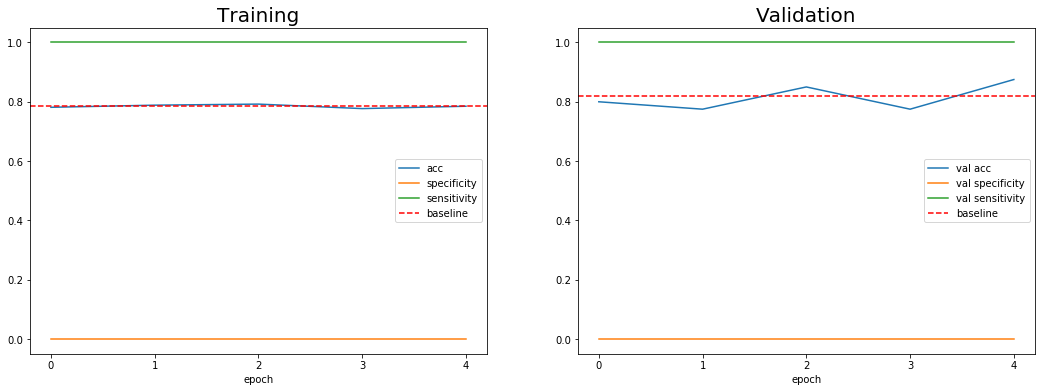

In [8]:
plt.figure(figsize = (18,6))
plt.subplot(1,2,1); plt.title('Training', fontsize = 20)
plt.plot(history.history['acc'], label = 'acc')
plt.plot(history.history['specificity'], label = 'specificity')
plt.plot(history.history['sensitivity'], label = 'sensitivity')
plt.axhline((train_data.temp_label).astype('float32').sum()/train_data.shape[0], ls = '--', c = 'r', label = 'baseline')
plt.xticks(np.arange(0,epochs)); plt.xlabel('epoch')
plt.legend()
plt.subplot(1,2,2); plt.title('Validation', fontsize = 20)
plt.plot(history.history['val_acc'], label = 'val acc')
plt.plot(history.history['val_specificity'], label = 'val specificity')
plt.plot(history.history['val_sensitivity'], label = 'val sensitivity')
plt.axhline((test_data.temp_label).astype('float32').sum()/test_data.shape[0], ls = '--', c = 'r', label = 'baseline')
plt.xticks(np.arange(0,epochs));plt.xlabel('epoch')
plt.legend();

In [9]:
addresses_gsv_filename = ['1_ESSEX_ST.jpg', '8_GILMAN_ST.jpg', '9_MELVILLE_RD.jpg','10_CENTRAL_ST.jpg',
                         '14_MANSFIELD_ST.jpg']
pred_sample = sample[sample.gsv_filename.isin(addresses_gsv_filename)]
pred_sample

,ADDR_NUM,FULL_STR,MBL,ADDRESS_FOR_STREET_VIEW,AERIAL_Driveway,GSV_Driveway,final_label,aerial_filename,gsv_filename,temp_label
0,1,ESSEX ST,50-B-12,"1 ESSEX ST, SOMERVILLE, MA",2,1,0.9,1_ESSEX_ST_aerial.png,1_ESSEX_ST.jpg,1
25,8,GILMAN ST,92-J-10,"8 GILMAN ST, SOMERVILLE, MA",1,2,0.9,8_GILMAN_ST_aerial.png,8_GILMAN_ST.jpg,1
37,9,MELVILLE RD,55-C-13,"9 MELVILLE RD, SOMERVILLE, MA",1,1,1.0,9_MELVILLE_RD_aerial.png,9_MELVILLE_RD.jpg,1
51,10,CENTRAL ST,44-F-8,"10 CENTRAL ST, SOMERVILLE, MA",0,0,0.0,10_CENTRAL_ST_aerial.png,10_CENTRAL_ST.jpg,0
78,14,MANSFIELD ST,81-B-16,"14 MANSFIELD ST, SOMERVILLE, MA",2,2,0.5,14_MANSFIELD_ST_aerial.png,14_MANSFIELD_ST.jpg,0


In [11]:
model.predict_generator(
    generator_three_inputs(pred_sample, tabular_df, [ 'test_col', 'test_col2'],                       
                           aerial_dir = '../data/training/aerial_images/', 
                           gsv_dir ='../data/training/sv_images/', 
                           batch_size = batch_size, 
                           gsv_image_dim = (128,128, 3), aer_image_dim = (128,128, 4) , 
                           y_column = 'temp_label'),
    
                        
                      steps = 1 )

Found 5 validated image filenames.
Found 5 validated image filenames belonging to 2 classes.


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [26]:
# Save the model architecture
with open('../models/model_architecture.json', 'w') as f:
    f.write(model.to_json())

In [27]:
# save basic model
import pickle
with open('../models/imageandtabular_modelhistory.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [28]:
model.save('../models/imageandtabular_model.h5', save_format='tf')

In [29]:
model.save_weights('../models/imageandtabular_model_weights.h5')

In [ ]:
model = combined_cnn(gsv_image_dim = (128,128, 3), sat_image_dim = ((128,128, 4)), 
                     n_classes = 1)